In [11]:
import logging
import pathlib
import os
import tempfile
import subprocess
import time 
import json
import concurrent.futures

import pandas as pd
import seaborn
import pydub
from tqdm.notebook import tqdm
import boto3


tqdm.pandas()
logger = logging.getLogger(__name__)

# Constants

In [3]:
bucket = "barbero-tts2"
region = "eu-central-1"
vocabulary_file = pathlib.Path("vocabulary/vocabulary.txt")
vocabulary_name = "barbero-guerre"
data_local = pathlib.Path("../data")
frame_rate = 16000
max_chunk_duration_seconds = 10
target_normalization_db = -23

In [89]:
boto3.setup_default_session(region_name=region)

# Convert original file to wav

In [3]:
lines = pd.read_csv("../data/original_files.csv")
lines["from"] = lines["from"].apply(pd.Timedelta)
lines["to"] = lines["to"].apply(pd.Timedelta)
lines

,original_audio,from,to
0,/hd4tb/archivio_barbero/7_La_Prima_Guerra_Mond...,0 days 00:01:23,0 days 01:09:48
1,/hd4tb/archivio_barbero/8_Come_scoppiano_le_gu...,0 days 00:00:00,0 days 01:07:37
2,/hd4tb/archivio_barbero/9_La_Guerra_delle_Falk...,0 days 00:00:55,0 days 01:01:36


In [4]:
def convert(row):
    input_file = pathlib.Path(row["original_audio"])
    folder = input_file.parent
    name = input_file.stem
    output_name = folder / "wav" / f"{name}.wav"
    sound = pydub.AudioSegment.from_mp3(input_file)
    sound = sound.set_channels(1)  # save to mono
    # cut the section between from and to
    beginning = 1000 * int(row["from"].total_seconds())
    end = 1000 * int(row["to"].total_seconds())
    sound = sound[beginning:end]
    sound.set_frame_rate(frame_rate)
    sound.export(output_name, format="wav")
    logger.debug("converted %s to %s", input_file, output_name)
    return output_name

In [5]:
lines["wav"] = lines.progress_apply(convert, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

# Normalize

In [6]:
def normalize(row):
    input_file = pathlib.Path(row["wav"])
    folder = input_file.parent
    name = input_file.stem
    output_name = folder / "normalized_wav" / f"{name}.wav"
    # stupid business with using a non-ext4 filesystem
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_out_name = pathlib.Path(tmpdirname) / output_name.name
        command = f"ffmpeg-normalize -f --normalization-type rms --target-level {target_normalization_db} {row['wav']} -o {temp_out_name}"
        subprocess.check_call(command, shell=True)
        command = f"mv {temp_out_name} {output_name}"
        subprocess.check_call(command, shell=True)
    return output_name

In [7]:
lines["normalized_wav"] = lines.progress_apply(normalize, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

mv: preserving times for '/hd4tb/archivio_barbero/wav/normalized_wav/7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_guerre__Barbero_Riserva_Festival_della_Mente_2014.wav': Operation not permitted
mv: preserving times for '/hd4tb/archivio_barbero/wav/normalized_wav/8_Come_scoppiano_le_guerre_La_seconda_guerra_mondiale_2014_2.wav': Operation not permitted
mv: preserving times for '/hd4tb/archivio_barbero/wav/normalized_wav/9_La_Guerra_delle_Falkland_-_Come_scoppiano_le_guerre_-_Barbero_Riserva_Festival_della_Mente_2014.wav': Operation not permitted


# Split wav file into chunks

In [8]:
def load_sound(row):
    sound = pydub.AudioSegment.from_file(row["normalized_wav"], format="wav")
    return sound

In [9]:
lines["sound"] = lines.apply(load_sound, axis=1)

In [25]:
def split_row_on_silence(row, min_silence_len, silence_thresh):
    chunks = pydub.silence.split_on_silence(
        row["sound"],
        min_silence_len=min_silence_len,
        silence_thresh=silence_thresh,
        keep_silence=True,
    )
    durations = pd.DataFrame(
        {
            "sound": chunks,
            "duration": [chunk.duration_seconds for chunk in chunks],
        }
    )
    durations["normalized_wav"] = row["normalized_wav"]
    return durations

def split_on_silence(df, max_chunk_duration_seconds, initial_min_silence_len, min_silence_len_steps, silence_thresh):
    chunks = df.progress_apply(
        split_row_on_silence,
        axis=1,
        min_silence_len=initial_min_silence_len,
        silence_thresh=silence_thresh
    )
    output = pd.concat(chunks.tolist()).reset_index(drop=True)
    too_long = output[output["duration"] > max_chunk_duration_seconds]
    ok_length = output[output["duration"] <= max_chunk_duration_seconds]
    if too_long.empty:
        return ok_length
    elif (initial_min_silence_len - min_silence_len_steps) < 0:
        return output
    else:
        fixed_output = pd.concat((
            ok_length,
            split_on_silence(
                df=too_long,
                max_chunk_duration_seconds=max_chunk_duration_seconds,
                initial_min_silence_len=initial_min_silence_len - min_silence_len_steps,
                min_silence_len_steps=min_silence_len_steps,
                silence_thresh=silence_thresh
            ))).reset_index(drop=True)
        return fixed_output

In [26]:
chunks = split_on_silence(
    lines,
    max_chunk_duration_seconds,
    initial_min_silence_len=1500,
    min_silence_len_steps=300,
    silence_thresh=-29
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [27]:
chunks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sound           2386 non-null   object 
 1   duration        2386 non-null   float64
 2   normalized_wav  2386 non-null   object 
dtypes: float64(1), object(2)
memory usage: 56.0+ KB


<AxesSubplot: ylabel='duration'>

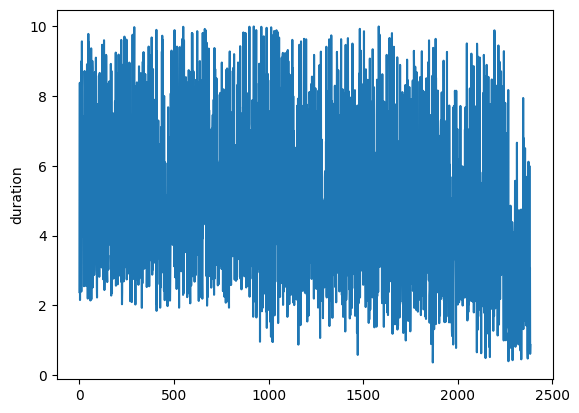

In [28]:
seaborn.lineplot(x=chunks.index, y=chunks.duration)

<AxesSubplot: xlabel='duration', ylabel='Count'>

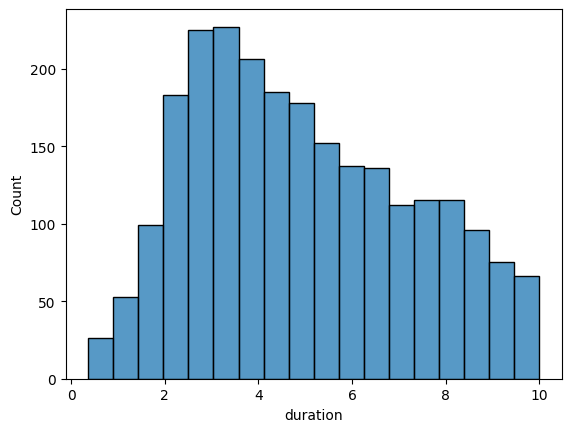

In [29]:
seaborn.histplot(chunks.duration)

In [30]:
def save_chunk(row):
    original_audio = pathlib.Path(row["normalized_wav"])
    folder = original_audio.parent.parent.parent / "splits" / original_audio.stem
    folder.mkdir(exist_ok=True, parents=True)
    output_name = folder / f"{row['index']:04}.wav"
    row["sound"].export(output_name, format="wav")
    return output_name

In [31]:
chunks["index"] = chunks.groupby("normalized_wav", as_index=False).cumcount()

In [32]:
chunks["path"] = chunks.progress_apply(save_chunk, axis=1)

  0%|          | 0/2386 [00:00<?, ?it/s]

In [82]:
chunks["sound"].iloc[0]

In [34]:
chunks["sound"].iloc[20]

# Upload Files to S3

In [45]:
storage_client = boto3.client("s3")
response = storage_client.upload_file(data_local / vocabulary_file, bucket, str(vocabulary_file))

In [51]:
def upload(row, storage_client, bucket):
    object_name = f"splits/{pathlib.Path(row['normalized_wav']).stem}/{pathlib.Path(row['path']).name}"
    storage_client.upload_file(row["path"], bucket, object_name)
    return f"s3://{bucket}/{object_name}"

In [52]:
chunks["s3_uri"] = chunks.progress_apply(upload, axis=1, storage_client=storage_client, bucket=bucket)

  0%|          | 0/2386 [00:00<?, ?it/s]

# Create vocabulary

In [90]:
transcribe_client = boto3.client('transcribe')

In [ ]:
words = pd.read_csv(data_local / vocabulary_file)
words["Phrases"] = words["Phrases"].str.replace(" ", "-")

In [ ]:
transcribe_client.delete_vocabulary(VocabularyName=vocabulary_name)
time.sleep(15)
response = transcribe_client.create_vocabulary(
    LanguageCode='it-IT',
    VocabularyName=vocabulary_name,
    Phrases=words["Phrases"].tolist(),
)

In [ ]:
while True:
    status = transcribe_client.get_vocabulary(VocabularyName=vocabulary_name)
    if status['VocabularyState'] in ['READY', 'FAILED']:
        break
    print("Not ready yet...")
    time.sleep(5)
print(status)

# Checkpoint to hard disk

In [132]:
chunks.to_pickle("/hd4tb/archivio_barbero/splits/notebook/chunks.pkl.gz")

In [206]:
# chunks = chunks.head(100).copy()

# Speech to Text: Transcribe

In [208]:
def speech_to_text(row, client):
    job_name = f'{row["path"].parent.name}-{row["path"].stem}'
    output_key = f"transcriptions/{job_name}.json"
    client.start_transcription_job(
        TranscriptionJobName=job_name,
        OutputBucketName=bucket,
        OutputKey=output_key,
        Media={'MediaFileUri': row["s3_uri"]},
        MediaFormat='wav',
        LanguageCode='it-IT',
        Settings={
            "VocabularyName": vocabulary_name,

        },
        JobExecutionSettings={
            "AllowDeferredExecution": True,
            "DataAccessRoleArn": "arn:aws:iam::180517682866:role/s3-role",
        },
    )
    return job_name

In [212]:
chunks["job_name"] = chunks.progress_apply(speech_to_text, axis=1, client=transcribe_client)

  0%|          | 0/2386 [00:00<?, ?it/s]

In [222]:
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    def job_completed(job_name, transcribe_client):
        max_tries = 60
        while max_tries > 0:
            max_tries -= 1
            job = transcribe_client.get_transcription_job(TranscriptionJobName=job_name)
            job_status = job['TranscriptionJob']['TranscriptionJobStatus']
            if job_status in ['COMPLETED', 'FAILED']:
                if job_status == 'COMPLETED':
                    return job
            else:
                time.sleep(5)
    def job_completed_row(row, executor):
        return executor.submit(job_completed, job_name=row["job_name"], transcribe_client=transcribe_client)
    chunks["job_future"] = chunks.progress_apply(job_completed_row, axis=1, executor=executor)

  0%|          | 0/2386 [00:00<?, ?it/s]

In [223]:
chunks["job"] = chunks["job_future"].progress_apply(lambda x: x.result())

  0%|          | 0/2386 [00:00<?, ?it/s]

In [225]:
def get_transcript_file_uri(job):
    if job is None:
        return None
    else:
        return job.get("TranscriptionJob", {}).get("Transcript", {}).get("TranscriptFileUri")

In [226]:
chunks["transcript_file_uri"] = chunks["job"].apply(get_transcript_file_uri)

# Extract the speech to text results

In [ ]:
def download_transcript(row, bucket, storage_client):
    uri = row["transcript_file_uri"]
    key = uri.replace(f"https://s3.{region}.amazonaws.com/{bucket}/", "")
    o = storage_client.get_object(Bucket=bucket, Key=key)
    transcript = json.load(o["Body"])
    if transcript["status"] == "COMPLETED":
        result = pd.Series({
            "path": row["path"],
            "status": transcript["status"],
            "transcript": transcript["results"]["transcripts"][0]["transcript"]
        })
    else:
        result = pd.Series({
            "path": row["path"],
            "status": transcript["status"],
            "transcript": transcript["status"]
        })
    return result

In [227]:
transcribed = chunks[chunks["transcript_file_uri"].notnull()].progress_apply(
    download_transcript,
    axis=1,
    bucket=bucket,
    storage_client=storage_client,
)

  0%|          | 0/2380 [00:00<?, ?it/s]

In [228]:
merged = pd.merge(chunks, transcribed, on="path")

In [229]:
merged.to_excel("../data/merged.xlsx", index=False)

In [241]:
def delete_job(row, transcribe_client):
    try:
        transcribe_client.delete_transcription_job(TranscriptionJobName=row["job_name"])
    except Exception:
        pass
    time.sleep(0.1)
_ = merged.progress_apply(delete_job, axis=1, transcribe_client=transcribe_client)

  0%|          | 0/2380 [00:00<?, ?it/s]

# Clean the transcriptions

In [234]:
cleaning = {
    "c' è": "c'è",
    "c', è": "c'è",
    "c'. è": "c'è",
    "\bé\b": "è",
    "gay": "Gray",
    "\.$": "",
}

In [235]:
merged["clean_transcript"] = merged["transcript"]
for key, value in cleaning.items():
    merged["clean_transcript"] = merged["clean_transcript"].str.replace(key, value, regex=True)

In [236]:
merged["clean_transcript"]

0                                come scoppiano le guerre
1       per esempio nell'europa del millenovecento qua...
2       allora la prima cosa importante da dire sullo ...
3                                         e il terrorismo
4       che so abbattere due grattacieli con tremila p...
                              ...                        
2375                      che appoggia la giunta militare
2376                              e che al suo confidente
2377             americano dice questo politico argentino
2378                                                  eh?
2379                                                ormai
Name: clean_transcript, Length: 2380, dtype: object

In [242]:
merged.drop(columns=["job", "job_future"]).to_pickle("../data/merged.pkl.gz")

In [4]:
merged = pd.read_pickle("../data/merged.pkl.gz")

In [5]:
merged

,sound,duration,normalized_wav,index,path,s3_uri,job_name,transcript_file_uri,status,transcript,clean_transcript
0,(((<pydub.audio_segment.AudioSegment object at...,2.381995,/hd4tb/archivio_barbero/wav/normalized_wav/7_L...,0,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,s3://barbero-tts2/splits/7_La_Prima_Guerra_Mon...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,come scoppiano le guerre.,come scoppiano le guerre
1,(((<pydub.audio_segment.AudioSegment object at...,6.520000,/hd4tb/archivio_barbero/wav/normalized_wav/7_L...,1,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,s3://barbero-tts2/splits/7_La_Prima_Guerra_Mon...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,per esempio nell'europa del millenovecento qua...,per esempio nell'europa del millenovecento qua...
2,(((<pydub.audio_segment.AudioSegment object at...,8.385011,/hd4tb/archivio_barbero/wav/normalized_wav/7_L...,2,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,s3://barbero-tts2/splits/7_La_Prima_Guerra_Mon...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,allora la prima cosa importante da dire sullo ...,allora la prima cosa importante da dire sullo ...
3,(((<pydub.audio_segment.AudioSegment object at...,2.153991,/hd4tb/archivio_barbero/wav/normalized_wav/7_L...,3,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,s3://barbero-tts2/splits/7_La_Prima_Guerra_Mon...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,e il terrorismo.,e il terrorismo
4,(((<pydub.audio_segment.AudioSegment object at...,4.148005,/hd4tb/archivio_barbero/wav/normalized_wav/7_L...,4,/hd4tb/archivio_barbero/splits/7_La_Prima_Guer...,s3://barbero-tts2/splits/7_La_Prima_Guerra_Mon...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,che so abbattere due grattacieli con tremila p...,che so abbattere due grattacieli con tremila p...
...,...,...,...,...,...,...,...,...,...,...,...
2375,(((<pydub.audio_segment.AudioSegment object at...,2.290998,/hd4tb/archivio_barbero/wav/normalized_wav/9_L...,749,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...,s3://barbero-tts2/splits/9_La_Guerra_delle_Fal...,9_La_Guerra_delle_Falkland_-_Come_scoppiano_le...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,che appoggia la giunta militare.,che appoggia la giunta militare
2376,(((<pydub.audio_segment.AudioSegment object at...,1.834989,/hd4tb/archivio_barbero/wav/normalized_wav/9_L...,750,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...,s3://barbero-tts2/splits/9_La_Guerra_delle_Fal...,9_La_Guerra_delle_Falkland_-_Come_scoppiano_le...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,e che al suo confidente.,e che al suo confidente
2377,(((<pydub.audio_segment.AudioSegment object at...,3.072993,/hd4tb/archivio_barbero/wav/normalized_wav/9_L...,751,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...,s3://barbero-tts2/splits/9_La_Guerra_delle_Fal...,9_La_Guerra_delle_Falkland_-_Come_scoppiano_le...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,americano dice questo politico argentino.,americano dice questo politico argentino
2378,(((<pydub.audio_segment.AudioSegment object at...,0.611020,/hd4tb/archivio_barbero/wav/normalized_wav/9_L...,752,/hd4tb/archivio_barbero/splits/9_La_Guerra_del...,s3://barbero-tts2/splits/9_La_Guerra_delle_Fal...,9_La_Guerra_delle_Falkland_-_Come_scoppiano_le...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,eh?,eh?


In [6]:
def write_wavs(row):
    path = pathlib.Path(row['path'])
    folder = pathlib.Path(f"/ssd500gb/archivio_barbero/split_wav/{path.parent.name}")
    folder.mkdir(exist_ok=True, parents=True)
    output_name = f"{folder}/{path.name}"
    row["sound"].export(output_name, format="wav")
    return output_name

In [14]:
merged["audio_file"] = merged.apply(write_wavs, axis=1)

In [15]:
final = merged[["audio_file", "clean_transcript"]].rename(columns={"clean_transcript": "text"})
final["audio_file"] = final["audio_file"].apply(lambda x: pathlib.Path(x).relative_to(pathlib.Path(x).parent.parent))

In [17]:
final.to_csv("../data/audio_metadata.csv", index=False, sep="|")